# Info

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Libraries Import

In [2]:
import glob
import cv2
import tqdm

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import os
from collections import Counter
import random
import re
import json
import pickle

In [5]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

In [7]:
from concurrent.futures import ThreadPoolExecutor

In [8]:
import kagglehub

In [9]:
import gradio as gr

# Constants

In [10]:
# BASE_DIR = r'/content/drive/MyDrive/similarity_learning'
BASE_DIR = ''

In [11]:
SENTENCE_MAX_WORDS_LEN = 35
OOV_TOKEN = '<OOV>'
EMBEDDING_DIM = 100 # Using GLoVe 100d

In [12]:
EPOCHS = 20
BATCH_SIZE = 1012

VAL_SPLIT = 0.2
TEST_SPLIT = 0.2

RONDOM_STATE = 42
np.random.seed(RONDOM_STATE)

In [13]:
CACHE_MODELS_DIR_NAME = os.path.join(BASE_DIR, 'train_cache')
os.makedirs(CACHE_MODELS_DIR_NAME, exist_ok=True)

In [14]:
DEPLOYMENST_PATH = os.path.join(BASE_DIR, 'deployments')
os.makedirs(DEPLOYMENST_PATH, exist_ok=True)

TOKENIZER_PATH = os.path.join(DEPLOYMENST_PATH, 'x_tokenizer.pkl')

# Functions

In [15]:
def save_obj(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

In [16]:
def save_obj_json(obj, file_name):
    with open(file_name, 'w', encoding='utf-8') as f:
        json.dump(obj, f, ensure_ascii=False, indent=4)

def load_obj_json(file_name):
    with open(file_name, 'r', encoding='utf-8') as f:
        return json.load(f)

In [17]:
def count_words_in_sentence(sentence):
    words = str(sentence).split(" ")
    words = list(filter(lambda x: x.strip() != "", words))
    return len(words)

# Dataset Download

In [18]:
path = kagglehub.dataset_download("thedevastator/quora-duplicate-questions-detection")

csv_path = os.path.join(path, r"quora_duplicate_questions.csv")

print("Path to dataset files:", path)
print("Path to csv:", csv_path)


Path to dataset files: C:\Users\yosef\.cache\kagglehub\datasets\thedevastator\quora-duplicate-questions-detection\versions\2
Path to csv: C:\Users\yosef\.cache\kagglehub\datasets\thedevastator\quora-duplicate-questions-detection\versions\2\quora_duplicate_questions.csv


# GLoVe Weights Download

In [19]:
path = kagglehub.dataset_download("danielwillgeorge/glove6b100dtxt")

glove_path = os.path.join(path, r"glove.6B.100d.txt")

print("Path to dataset files:", path)
print("Path to glove file:", glove_path)

Path to dataset files: C:\Users\yosef\.cache\kagglehub\datasets\danielwillgeorge\glove6b100dtxt\versions\1
Path to glove file: C:\Users\yosef\.cache\kagglehub\datasets\danielwillgeorge\glove6b100dtxt\versions\1\glove.6B.100d.txt


# Dataset Read

In [20]:
df = pd.read_csv(csv_path)

# Exploration

In [21]:
pd.concat([df.head(5), df.tail(5)])

,index,id,qid1,qid2,question1,question2,is_duplicate
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
4,4,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
345031,345031,404345,789790,789791,What does Jainism say about homosexuality?,What does Jainism say about Gays and Homosexua...,1
345032,345032,404346,789792,789793,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
345033,345033,404347,789794,789795,Do you believe there is life after death?,Is it true that there is life after death?,1
345034,345034,404348,789796,789797,What is one coin?,What's this coin?,0
345035,345035,404350,789800,789801,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345036 entries, 0 to 345035
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         345036 non-null  int64 
 1   id            345036 non-null  int64 
 2   qid1          345036 non-null  int64 
 3   qid2          345036 non-null  int64 
 4   question1     345035 non-null  object
 5   question2     345034 non-null  object
 6   is_duplicate  345036 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 18.4+ MB


In [23]:
df.describe(include='all')

,index,id,qid1,qid2,question1,question2,is_duplicate
count,345036.000000,345036.000000,345036.000000,345036.000000,345035,345034,345036.000000
unique,NaN,NaN,NaN,NaN,248048,253242,NaN
top,NaN,NaN,NaN,NaN,How do I improve my English speaking?,What are the best ways to lose weight?,NaN
freq,NaN,NaN,NaN,NaN,50,111,NaN
mean,172517.500000,202167.901978,391861.413351,390032.565332,NaN,NaN,0.394973
std,99603.458078,116719.472849,228406.445188,228827.555423,NaN,NaN,0.488846
min,0.000000,0.000000,1.000000,2.000000,NaN,NaN,0.000000
25%,86258.750000,101066.000000,193340.500000,190723.500000,NaN,NaN,0.000000
50%,172517.500000,202134.500000,390546.000000,388065.000000,NaN,NaN,0.000000
75%,258776.250000,303269.250000,589615.250000,587984.500000,NaN,NaN,1.000000


In [24]:
print("N Rows:", len(df))

N Rows: 345036


In [25]:
print("Number of duplicate questions:", df.duplicated().sum())

Number of duplicate questions: 0


In [26]:
(100 * df.isna().sum() / len(df)).sort_values(ascending=False)

question2       0.00058
question1       0.00029
index           0.00000
qid1            0.00000
id              0.00000
qid2            0.00000
is_duplicate    0.00000
dtype: float64

# Visualization

In [27]:
plt.style.use(plt.style.available[12])

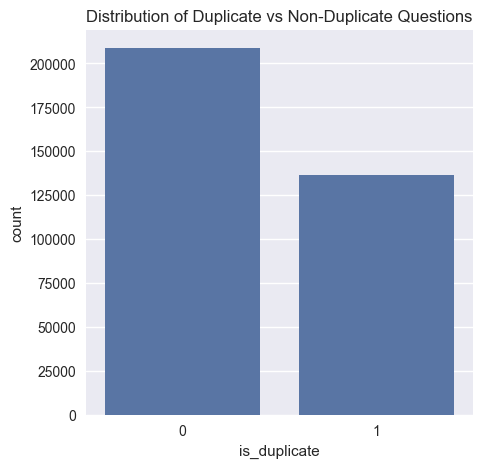

In [28]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='is_duplicate')
plt.title("Distribution of Duplicate vs Non-Duplicate Questions")
plt.show()

Text(0.5, 1.0, 'Distribution of Question Lengths')

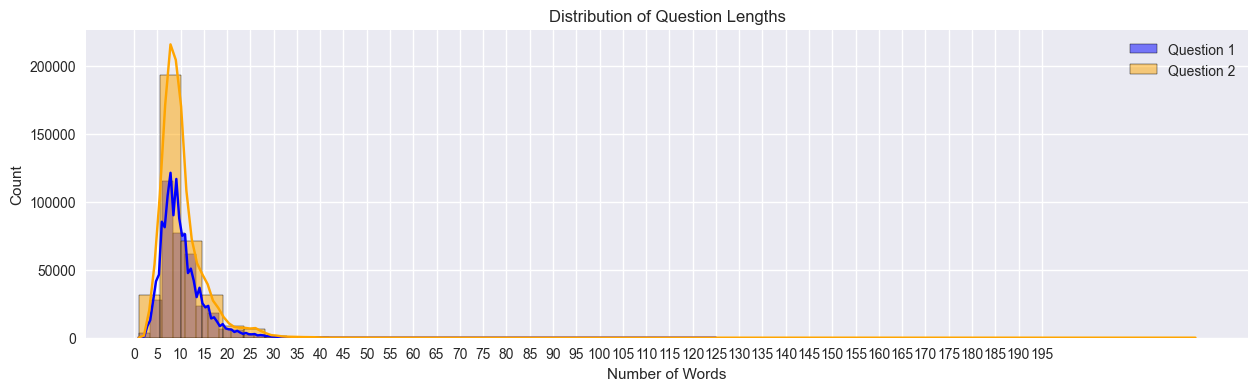

In [29]:
plt.figure(figsize=(15,4))
sns.histplot( [count_words_in_sentence(x) for x in df['question1'].values ], bins=50, color='blue', label='Question 1', kde=True)
sns.histplot( [count_words_in_sentence(x) for x in df['question2'].values ], bins=50, color='orange', label='Question 2', kde=True)
plt.legend()
plt.xticks(range(0, 200, 5))
plt.xlabel('Number of Words')
plt.title('Distribution of Question Lengths')

# Data Preprocessing

Null values

In [30]:
df.dropna(inplace=True)

Duplicates

In [31]:
df.drop_duplicates(inplace=True)

Drop too long sentence

In [32]:
print("Number of samples before:", len(df))

df = df[df['question1'].apply(count_words_in_sentence) <= SENTENCE_MAX_WORDS_LEN]
df = df[df['question2'].apply(count_words_in_sentence) <= SENTENCE_MAX_WORDS_LEN]

print("Number of samples after:", len(df))

Number of samples before: 345033
Number of samples after: 343779


Drop Cols

In [33]:
xy_df = df.loc[:, ['question1', 'question2', 'is_duplicate']]

sentences preprocessing

In [34]:
def clean_str(sentence):
    sentence = str(sentence)
    sentence = sentence.lower()
    sentence = re.sub(r"[^a-zA-Z0-9]", " ", sentence)

    # Add space between numbers followed by letters (e.g., "12cm" -> "12 cm")
    sentence = re.sub(r"(\d)([a-zA-Z])", r"\1 \2", sentence)

    # Add space between letters followed by numbers (e.g., "cm12" -> "cm 12")
    sentence = re.sub(r"([a-zA-Z])(\d)", r"\1 \2", sentence)

    sentence = re.sub(r"\s+", " ", sentence).strip()
    return sentence


xy_df['question1'] = [clean_str(x) for x in tqdm.tqdm(xy_df['question1'].values)]
xy_df['question2'] = [clean_str(x) for x in tqdm.tqdm(xy_df['question2'].values)]

100%|██████████| 343779/343779 [00:04<00:00, 75005.52it/s]


In [35]:
xy_df.head()

,question1,question2,is_duplicate
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,should i buy tiago,what keeps childern active and far from phone ...,0
4,how can i be a good geologist,what should i do to be a great geologist,1


Notes

Our approach is to use pre-trained GloVe embeddings rather than training new ones.
Therefore, we will not apply stemming or lemmatization, since GloVe embeddings are trained on words in their original form.

# Corpus Extraction

Tokenization

In [36]:
if os.path.exists(TOKENIZER_PATH):
    print("📂 Loading tokenizer from cache...")
    x_tokenizer = load_obj(TOKENIZER_PATH)

else:
    print("⚙️ Creating new tokenizer...")
    x_tokenizer = Tokenizer(
        num_words=None,
        filters='',
        lower=None,
        split=' ',
        oov_token=OOV_TOKEN,
        char_level=False
    )

    x_tokenizer.fit_on_texts(
        list(xy_df['question1'].values) + list(xy_df['question2'].values)
    )

📂 Loading tokenizer from cache...


In [37]:
print("N Words in vocabulary:", len(x_tokenizer.word_index))

N Words in vocabulary: 70286


In [38]:
list(x_tokenizer.index_word.items())[0:20]

[(1, '<OOV>'),
 (2, 'the'),
 (3, 'what'),
 (4, 'is'),
 (5, 'how'),
 (6, 'i'),
 (7, 'a'),
 (8, 'to'),
 (9, 'in'),
 (10, 'do'),
 (11, 'are'),
 (12, 'of'),
 (13, 'can'),
 (14, 'and'),
 (15, 'for'),
 (16, 'you'),
 (17, 'why'),
 (18, 'best'),
 (19, 'my'),
 (20, 'it')]

In [39]:
xy_df['question1_seq'] = x_tokenizer.texts_to_sequences(xy_df['question1'].values)
xy_df['question2_seq'] = x_tokenizer.texts_to_sequences(xy_df['question2'].values)

xy_df.head()

,question1,question2,is_duplicate,question1_seq,question2_seq
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,"[3, 4, 2, 1237, 61, 1237, 2728, 8, 618, 9, 797...","[3, 4, 2, 1237, 61, 1237, 2728, 8, 618, 9, 797..."
1,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,"[3, 4, 2, 545, 12, 12322, 14424, 6, 17886, 4152]","[3, 58, 176, 37, 2, 82, 213, 11991, 2, 12322, ..."
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,"[5, 13, 6, 190, 2, 499, 12, 19, 328, 1847, 225...","[5, 13, 328, 499, 27, 3470, 61, 1161, 216, 9646]"
3,should i buy tiago,what keeps childern active and far from phone ...,0,"[28, 6, 128, 29295]","[3, 2698, 58821, 1468, 14, 1115, 35, 121, 14, ..."
4,how can i be a good geologist,what should i do to be a great geologist,1,"[5, 13, 6, 27, 7, 40, 23490]","[3, 28, 6, 10, 8, 27, 7, 357, 23490]"


Pad Sequence

In [40]:
xy_df['question1_seq'] = list(
    pad_sequences(xy_df['question1_seq'].values, maxlen=SENTENCE_MAX_WORDS_LEN, padding='post', truncating='post')
)

xy_df['question2_seq'] = list(
    pad_sequences(xy_df['question2_seq'].values, maxlen=SENTENCE_MAX_WORDS_LEN, padding='post', truncating='post')
)

print(xy_df.iloc[0,-1])
print(xy_df.iloc[0,-1].shape)

[   3    4    2 1237   61 1237 2728    8  618    9  797  362    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]
(35,)


GLoVe weights loading

In [41]:
glove_embeddings_index = {}
with open(glove_path, 'r', encoding='utf8') as f:
    for line in tqdm.tqdm(f):
        values = line.split()
        word = values[0]
        clean_word = clean_str(word)
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[clean_word] = coefs

print(f'Loaded {len(glove_embeddings_index)} word vectors from GloVe.')

400000it [00:12, 32408.12it/s]

Loaded 388657 word vectors from GloVe.


In [42]:
n_found = []
n_not_found = []

vocab_size = len(x_tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in tqdm.tqdm(x_tokenizer.word_index.items()):
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        n_found.append(word)
        embedding_matrix[i] = embedding_vector
    else:
        n_not_found.append(word)
        # For OOV words, you can leave zeros or initialize randomly
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))

100%|██████████| 70286/70286 [00:00<00:00, 430853.67it/s]


In [43]:
print("Embedding matrix shape:", embedding_matrix.shape)

print(f"Number of words found in GLoVe: {len(n_found)}")
print(f"Number of words NOT found in GLoVe: {len(n_not_found)}")

Embedding matrix shape: (70287, 100)
Number of words found in GLoVe: 53304
Number of words NOT found in GLoVe: 16982


In [44]:
save_obj_json(n_found, os.path.join(BASE_DIR,"n_found_words.json"))
save_obj_json(n_not_found, os.path.join(BASE_DIR,"n_not_found_words.json"))

# Words Visuals

In [45]:
pca = PCA(n_components=2)
projected_embedding_matrix = pca.fit_transform(embedding_matrix)

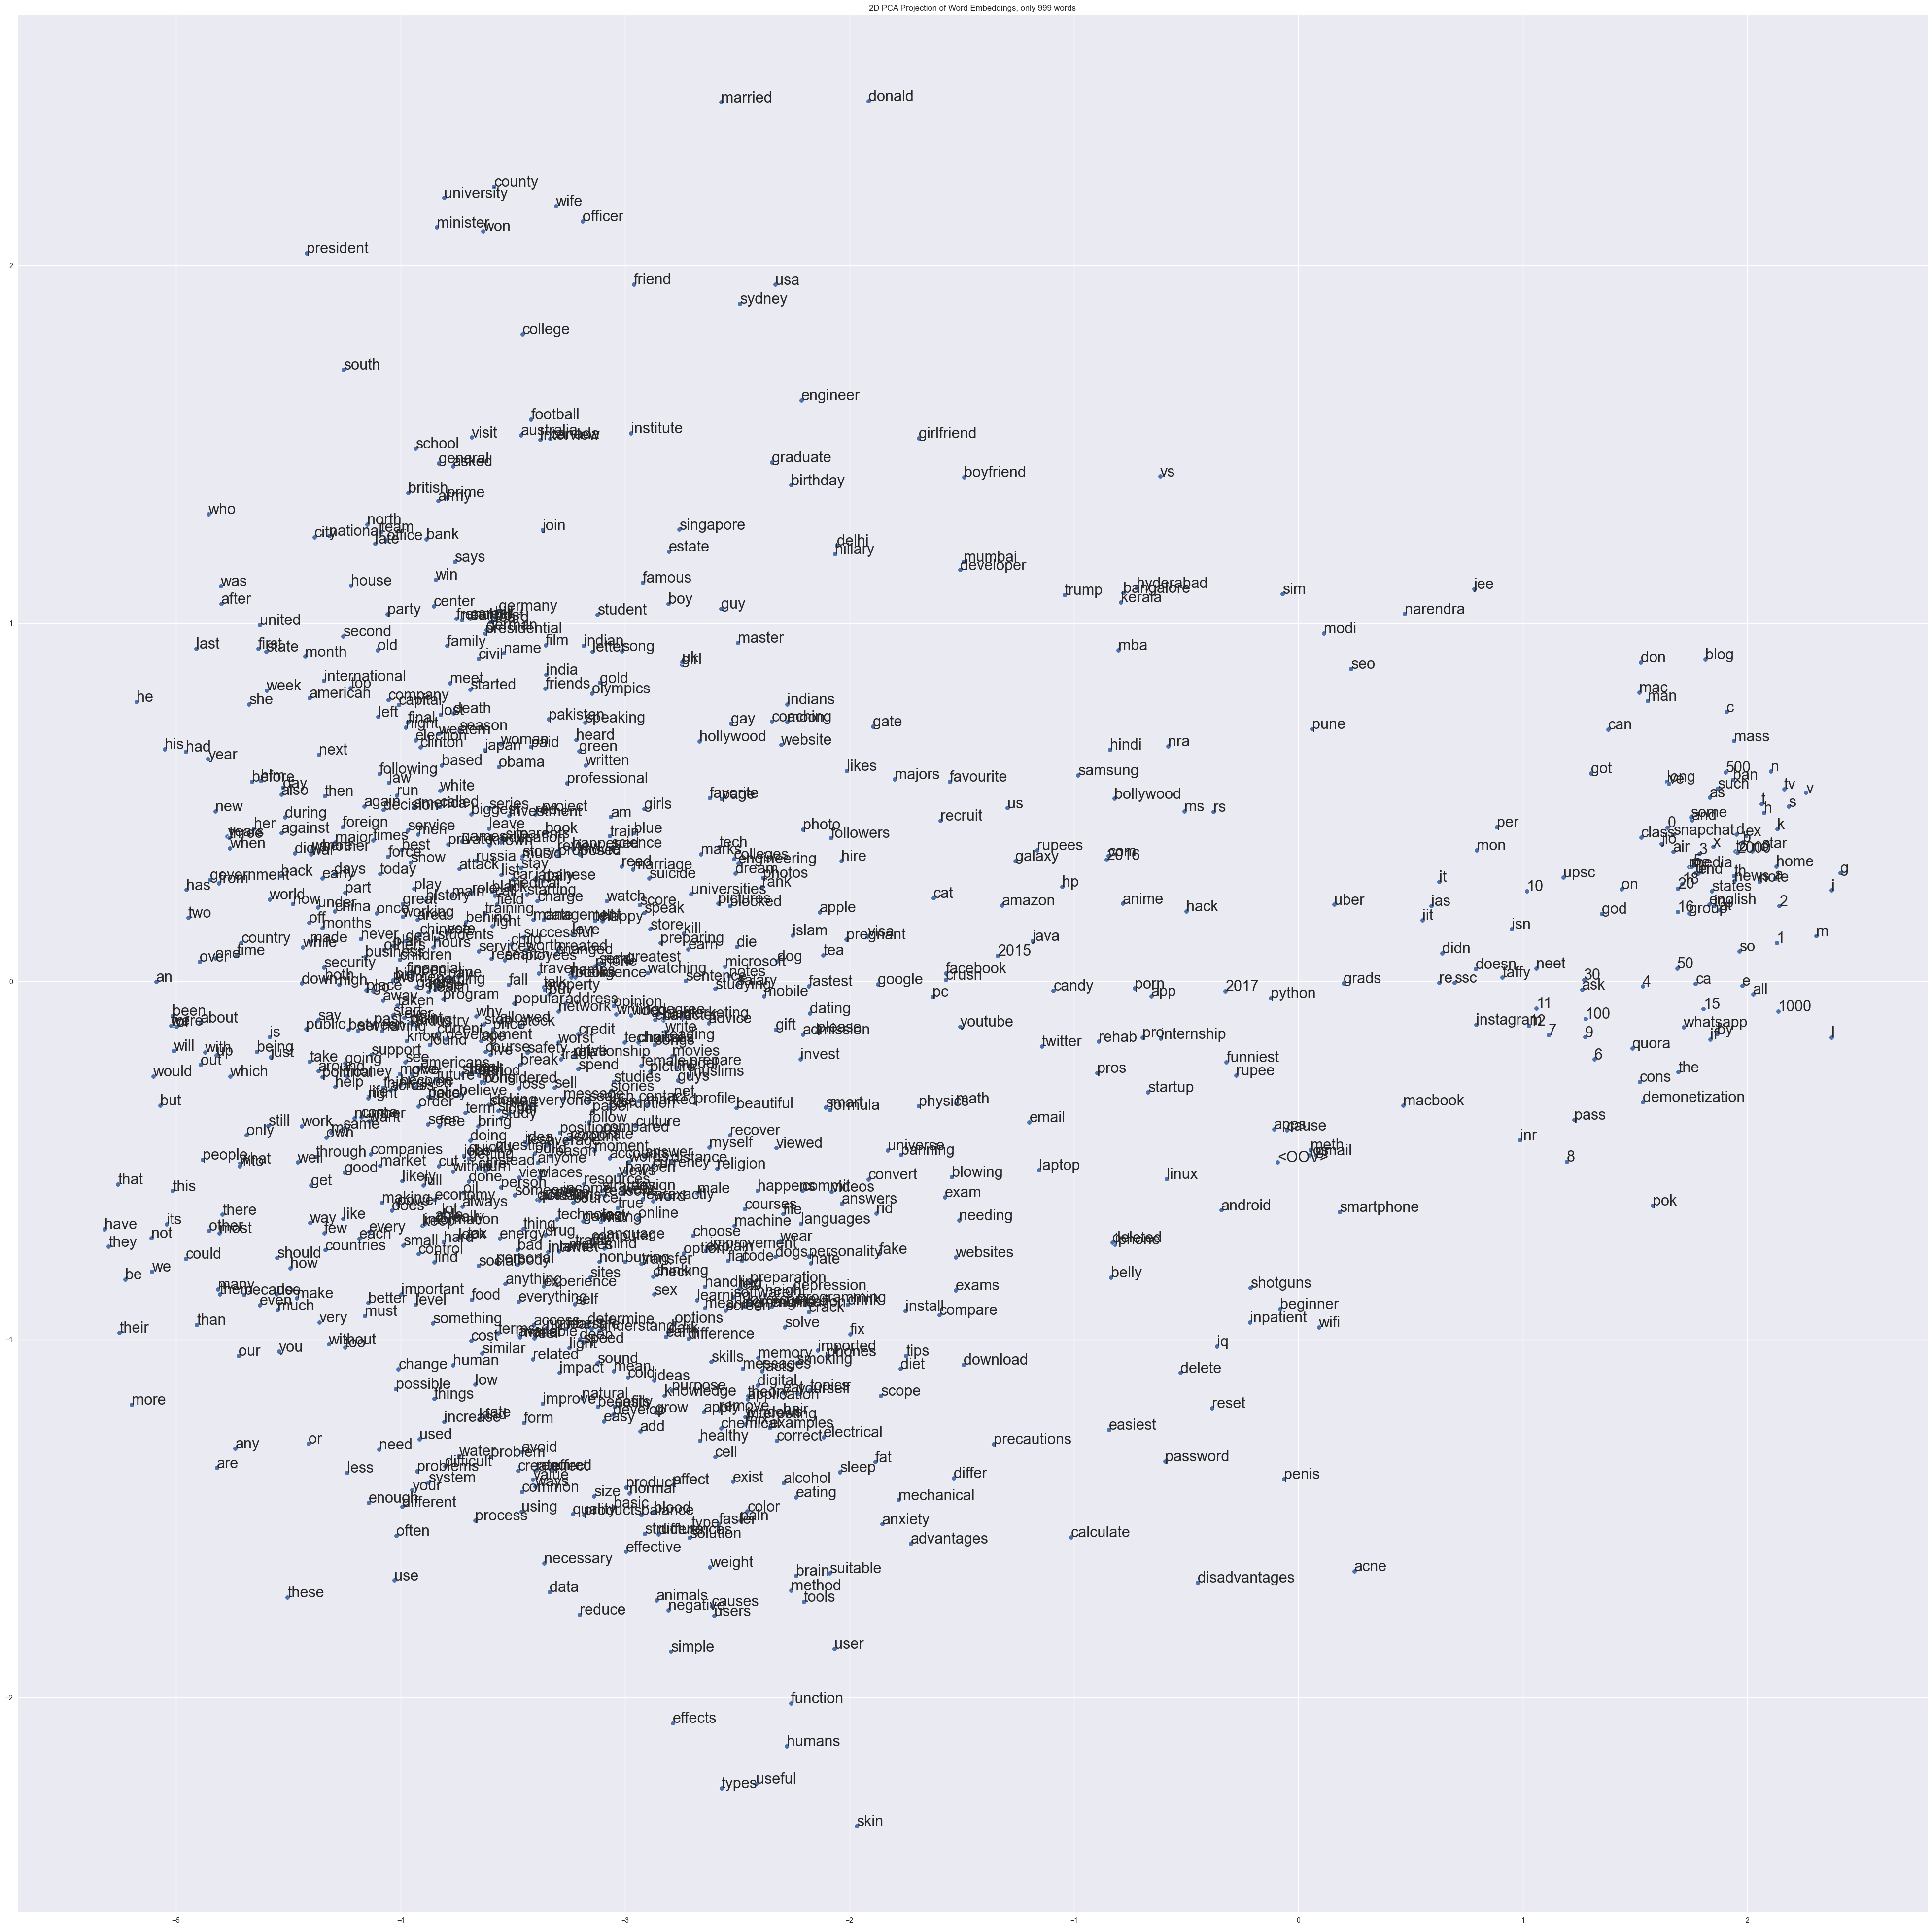

In [46]:
RANGE = np.arange(1, 1000)

plt.figure(figsize=(50, 50))
sns.scatterplot(
    x=projected_embedding_matrix[RANGE,0],
    y=projected_embedding_matrix[RANGE,1],
    s=50
    )

for i in RANGE:
    plt.text(
        projected_embedding_matrix[i,0],
        projected_embedding_matrix[i,1],
        x_tokenizer.index_word[i],
        fontsize=22
    )

plt.title(f"2D PCA Projection of Word Embeddings, only {RANGE[-1]} words")

plt.savefig(os.path.join(BASE_DIR,"word_embeddings_pca.png"), dpi=300, bbox_inches='tight')
plt.show()

# Data Split

In [47]:
X = np.array( [[x1, x2] for x1, x2 in zip(xy_df['question1_seq'].values, xy_df['question2_seq'].values) ] )
y = xy_df['is_duplicate'].values

In [48]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (343779, 2, 35)
y shape: (343779,)


In [49]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=VAL_SPLIT,
    random_state=RONDOM_STATE)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val,
    test_size=TEST_SPLIT/(TEST_SPLIT + VAL_SPLIT),
    random_state=RONDOM_STATE)

In [50]:
print("X train shape:\t", X_train.shape)
print("y train shape:\t", y_train.shape)
print("X val shape:\t", X_val.shape)
print("y val shape:\t", y_val.shape)
print("X test shape:\t", X_test.shape)
print("y test shape:\t", y_test.shape)

X train shape:	 (275023, 2, 35)
y train shape:	 (275023,)
X val shape:	 (34378, 2, 35)
y val shape:	 (34378,)
X test shape:	 (34378, 2, 35)
y test shape:	 (34378,)


# Model Encapsulation

In [51]:
class HistoryCheckpoint(Callback):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.filepath = os.path.join(CACHE_MODELS_DIR_NAME, f'{model_name}.history.json')
        self.history = {}

        if os.path.exists(self.filepath):
            with open(self.filepath, 'r') as f:
                self.history = json.load(f)
                print(F'Model {self.model_name} history loaded from cache')
        else:
            self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            self.history.setdefault(key, []).append(float(value))

        with open(self.filepath, 'w') as f:
            json.dump(self.history, f)

    def get_history(self):
        return self.history

In [52]:
class CustomModel:
    def __init__(self, name, entire_model, feature_extractor_model):
        self.name = re.sub('[^A-Za-z0-9]', '_', str(name)).lower()
        self.model = entire_model
        self.feature_extractor_model = feature_extractor_model
        self._history = {}
        self.load()

    def fit(self, x=None, y=None, validation_data=None, epochs=10, batch_size=None, force_train=False,
            class_weights=None):
        """
        Fit the model using (x, y) arrays or datasets.

        Parameters:
        - x, y: training data and labels (arrays or tensors)
        - validation_data: tuple (x_val, y_val) or generator
        - epochs: number of epochs
        - batch_size: batch size
        - force_train: whether to force training even if already trained
        - class_weights: optional class weights
        """
        file_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '.weights.h5'
        es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
        mcp = ModelCheckpoint(filepath=file_path, monitor='val_loss', save_best_only=True,
                              save_weights_only=True, mode='min', verbose=1)
        rop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
        hcp = HistoryCheckpoint(self.name)

        if not hasattr(self, 'trained') or self.trained is False or force_train:
            self.model.fit(
                x=x,
                y=y,
                validation_data=validation_data,
                epochs=epochs,
                batch_size=batch_size,
                class_weight=class_weights,
                callbacks=[es, mcp, rop, hcp]
            )
            self.trained = True
            self._history = hcp.get_history()
        else:
            self._history = hcp.get_history()

    @property
    def history(self):
        return self._history

    def load(self):
        file_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '.weights.h5'

        if os.path.exists(file_path):
            self.model.load_weights(file_path)
            self.trained = True
            print(f'Model {self.name} weights loaded from cache')
        else:
            self.trained = False
            print(f'Model {self.name} weights not found in cache, training required')

        hcp = HistoryCheckpoint(self.name)
        self._history = hcp.get_history()


# Models Arch

In [53]:
INPUT_SHAPE = X_train.shape[1:]
print("Input shape:", INPUT_SHAPE)

Input shape: (2, 35)


## Custom Layer

In [54]:
def create_embedding_layer():
    embedding_layer = Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix.copy()],
        input_length=SENTENCE_MAX_WORDS_LEN,
        trainable=True
    )
    return embedding_layer

In [55]:
def create_lstm_layer(units, return_sequences=False, dropout = 0.0):
    bi_lstm_layer = LSTM(units, return_sequences=return_sequences, dropout=dropout, recurrent_dropout=dropout)
    return bi_lstm_layer

In [56]:
def create_bi_lstm_layer(units, return_sequences=False, dropout = 0.0):
    bi_lstm_layer = Bidirectional(LSTM(units, return_sequences=return_sequences, dropout=dropout, recurrent_dropout=dropout))
    return bi_lstm_layer

In [57]:
def pass_squeeze_excitation_block(input_tensor, reduction_ratio=16):
    channels = int(input_tensor.shape[-1])

    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, channels))(se)

    # Excitation: Bottleneck fully-connected layers
    se = Dense(channels // reduction_ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)

    # Scale the input
    x = Multiply()([input_tensor, se])

    return x

In [58]:
def pass_positional_encoding(token_ids):
    positions = Lambda(
        lambda x: tf.tile(
            tf.range(SENTENCE_MAX_WORDS_LEN)[tf.newaxis, :],
            [tf.shape(x)[0], 1]
        ),
        output_shape=(SENTENCE_MAX_WORDS_LEN,),
        name="pos_indices"
    )(token_ids)

    pos_embedding = Embedding(
        input_dim=SENTENCE_MAX_WORDS_LEN,
        output_dim=EMBEDDING_DIM,
        trainable=True,
        name="pos_embedding"
    )(positions)

    return pos_embedding


In [59]:
def pass_add_and_norm(input_1, input_2):
  x = Add()([input_1, input_2])
  x = LayerNormalization()(x)

  return x

In [60]:
def pass_multi_head_attention(q, k, v, num_heads=8):
    mha = MultiHeadAttention(num_heads=num_heads, key_dim=EMBEDDING_DIM)
    x = mha(query=q, value=v, key=k)
    return x

In [61]:
def pass_ffn(x, ff_dim=2048, dropout_rate=0.1):
    y = Dense(ff_dim, activation='relu')(x)
    y = Dropout(dropout_rate)(y)
    y = Dense(EMBEDDING_DIM)(y)
    return y

## Models

In [62]:
models_list = list()

In [63]:
def build_model_1():
    global models_list
    NAME = "shallow_lstm_v1"

    feature_ext_input = Input(shape= INPUT_SHAPE[1:])

    u = create_embedding_layer()(feature_ext_input)
    u = create_lstm_layer(64, return_sequences=False, dropout=0.2)(u)

    feature_ext_model = Model(feature_ext_input, u)

    feature_ext_model.summary()

    #-------------------------

    entire_model_input = Input(shape= INPUT_SHAPE)

    v = TimeDistributed(feature_ext_model)(entire_model_input)

    v = Flatten()(v)

    v = Dense(64, activation='relu')(v)

    v = Dense(1, activation='sigmoid')(v)


    entire_model = Model(entire_model_input, v)

    entire_model.summary()

    entire_model.compile(optimizer='adam', loss='bce', metrics=['accuracy'])

    custom_model =  CustomModel(NAME, entire_model, feature_ext_model)

    models_list.append(custom_model)

build_model_1()

c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 35, 100)        │     7,028,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,070,940 (26.97 MB)

 Trainable params: 7,070,940 (26.97 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2, 35)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 2, 64)          │     7,070,940 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,079,261 (27.01 MB)

 Trainable params: 7,079,261 (27.01 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model shallow_lstm_v1 weights loaded from cache
Model shallow_lstm_v1 history loaded from cache


In [64]:
def build_model_2():
    global models_list
    NAME = "deep_lstm_v1"

    feature_ext_input = Input(shape= INPUT_SHAPE[1:])

    u = create_embedding_layer()(feature_ext_input)

    u = create_lstm_layer(64, return_sequences=True, dropout=0.1)(u)
    u = create_lstm_layer(64, return_sequences=False, dropout=0.1)(u)

    feature_ext_model = Model(feature_ext_input, u)

    feature_ext_model.summary()

    #-------------------------

    entire_model_input = Input(shape= INPUT_SHAPE)

    v = TimeDistributed(feature_ext_model)(entire_model_input)

    v = Lambda(lambda x: tf.expand_dims(x, axis=-1))(v)

    v = Conv2D(8, kernel_size=(2,1), activation='relu', padding='same')(v)
    v = Conv2D(16, kernel_size=(2,1), activation='relu', padding='same')(v)

    v = Flatten()(v)

    v = Dense(64, activation='relu')(v)

    v = Dense(32, activation='relu')(v)

    v = Dense(1, activation='sigmoid')(v)

    entire_model = Model(entire_model_input, v)

    entire_model.summary()

    entire_model.compile(optimizer='adam', loss='bce', metrics=['accuracy'])

    custom_model =  CustomModel(NAME, entire_model, feature_ext_model)

    models_list.append(custom_model)

build_model_2()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 35, 100)        │     7,028,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 35, 64)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,103,964 (27.10 MB)

 Trainable params: 7,103,964 (27.10 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2, 35)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 2, 64)          │     7,103,964 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 2, 64, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 2, 64, 8)       │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 2, 64, 16)      │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,237,509 (27.61 MB)

 Trainable params: 7,237,509 (27.61 MB)

 Non-trainable params: 0 (0.00 B)

Model deep_lstm_v1 weights loaded from cache
Model deep_lstm_v1 history loaded from cache


c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 36 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [65]:
def build_model_3():
    global models_list
    NAME = "deep_bi_lstm_v1"

    feature_ext_input = Input(shape= INPUT_SHAPE[1:])

    u = create_embedding_layer()(feature_ext_input)

    u = create_bi_lstm_layer(224, return_sequences=True, dropout=0.1)(u)
    u = create_bi_lstm_layer(224, return_sequences=False, dropout=0.1)(u)

    feature_ext_model = Model(feature_ext_input, u)

    feature_ext_model.summary()

    #-------------------------

    entire_model_input = Input(shape= INPUT_SHAPE)

    v = TimeDistributed(feature_ext_model)(entire_model_input)

    v = Lambda(lambda x: tf.expand_dims(x, axis=-1))(v)

    v = Conv2D(32, kernel_size=(2,1), activation='relu', padding='same')(v)
    v = Conv2D(64, kernel_size=(2,1), activation='relu', padding='same')(v)
    v = Conv2D(128, kernel_size=(2,1), activation='relu', padding='same')(v)

    v = AvgPool2D(pool_size=(2,4))(v)

    v = Flatten()(v)

    v = Dense(64, activation='relu')(v)

    v = Dense(32, activation='relu')(v)

    v = Dense(1, activation='sigmoid')(v)

    entire_model = Model(entire_model_input, v)

    entire_model.summary()

    entire_model.compile(optimizer='adam', loss='bce', metrics=['accuracy'])

    custom_model =  CustomModel(NAME, entire_model, feature_ext_model)

    models_list.append(custom_model)

build_model_3()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 35, 100)        │     7,028,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 35, 448)        │       582,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 448)            │     1,206,016 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,817,116 (33.63 MB)

 Trainable params: 8,817,116 (33.63 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 2, 35)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 2, 448)         │     8,817,116 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 2, 448, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 448, 32)     │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 448, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 448, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 112, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14336)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │       917,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,757,565 (37.22 MB)

 Trainable params: 9,757,565 (37.22 MB)

 Non-trainable params: 0 (0.00 B)

Model deep_bi_lstm_v1 weights loaded from cache
Model deep_bi_lstm_v1 history loaded from cache


c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [66]:
def build_model_4():
    global models_list
    NAME = "deep_bi_lstm_se_v1"

    feature_ext_input = Input(shape= INPUT_SHAPE[1:])

    u = create_embedding_layer()(feature_ext_input)

    u = create_bi_lstm_layer(224, return_sequences=True, dropout=0.1)(u)
    u = create_bi_lstm_layer(224, return_sequences=False, dropout=0.1)(u)

    feature_ext_model = Model(feature_ext_input, u)

    feature_ext_model.summary()

    #-------------------------

    entire_model_input = Input(shape= INPUT_SHAPE)

    v = TimeDistributed(feature_ext_model)(entire_model_input)

    v = Lambda(lambda x: tf.expand_dims(x, axis=-1))(v)

    v = Conv2D(32, kernel_size=(2,1), activation='relu', padding='same')(v)
    # v = pass_squeeze_excitation_block(v, reduction_ratio=16)

    v = Conv2D(64, kernel_size=(2,1), activation='relu', padding='same')(v)
    # v = pass_squeeze_excitation_block(v, reduction_ratio=16)

    v = Conv2D(128, kernel_size=(2,1), activation='relu', padding='same')(v)
    v = pass_squeeze_excitation_block(v, reduction_ratio=16)

    v = AvgPool2D(pool_size=(2,4))(v)

    v = Flatten()(v)

    v = Dense(64, activation='relu')(v)

    v = Dense(32, activation='relu')(v)

    v = Dense(1, activation='sigmoid')(v)

    entire_model = Model(entire_model_input, v)

    entire_model.summary()

    entire_model.compile(optimizer='adam', loss='bce', metrics=['accuracy'])

    custom_model =  CustomModel(NAME, entire_model, feature_ext_model)

    models_list.append(custom_model)

build_model_4()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 35, 100)        │     7,028,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 35, 448)        │       582,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 448)            │     1,206,016 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,817,116 (33.63 MB)

 Trainable params: 8,817,116 (33.63 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 2, 35)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 2, 448)    │  8,817,116 │ input_layer_7[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 2, 448, 1) │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 2, 448,    │         96 │ lambda_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 2, 448,    │      4,160 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 448,    │     16,512 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_7[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 128) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1, 1, 8)   │      1,032 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1, 1, 128) │      1,152 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 2, 448,    │          0 │ conv2d_7[0][0],   │
│                     │ 128)              │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 1, 112,    │          0 │ multiply[0][0]    │
│ (AveragePooling2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 14336)     │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │    917,568 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      2,080 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         33 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,759,749 (37.23 MB)

 Trainable params: 9,759,749 (37.23 MB)

 Non-trainable params: 0 (0.00 B)

Model deep_bi_lstm_se_v1 weights loaded from cache
Model deep_bi_lstm_se_v1 history loaded from cache


c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 60 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [67]:
def build_model_5():
    global models_list
    NAME = "shallow_lstm_v2"

    feature_ext_input = Input(shape= INPUT_SHAPE[1:])

    u = create_embedding_layer()(feature_ext_input)
    u = create_lstm_layer(64, return_sequences=False, dropout=0.2)(u)

    feature_ext_model = Model(feature_ext_input, u)

    feature_ext_model.summary()

    #-------------------------

    entire_model_input = Input(shape= INPUT_SHAPE)

    v = TimeDistributed(feature_ext_model)(entire_model_input)

    v = Flatten()(v)

    v = Dense(64, activation=None)(v)

    v = BatchNormalization()(v)

    v = LeakyReLU(alpha=0.01)(v)

    v = Dense(1, activation='sigmoid')(v)


    entire_model = Model(entire_model_input, v)

    entire_model.summary()

    entire_model.compile(optimizer='adam', loss='bce', metrics=['accuracy'])

    custom_model =  CustomModel(NAME, entire_model, feature_ext_model)

    models_list.append(custom_model)

build_model_5()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 35, 100)        │     7,028,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        42,240 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,070,940 (26.97 MB)

 Trainable params: 7,070,940 (26.97 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 2, 35)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 2, 64)          │     7,070,940 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,079,517 (27.01 MB)

 Trainable params: 7,079,389 (27.01 MB)

 Non-trainable params: 128 (512.00 B)

c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model shallow_lstm_v2 weights loaded from cache
Model shallow_lstm_v2 history loaded from cache


In [68]:
def build_model_6():
    global models_list
    NAME = "encoder_based_v1"

    feature_ext_input = Input(shape= INPUT_SHAPE[1:])

    u1 = create_embedding_layer()(feature_ext_input)
    u2 = pass_positional_encoding(u1)

    u = Add()([u1, u2])

    v = pass_multi_head_attention(u, u, u)
    u = pass_add_and_norm(u, v)

    v = pass_ffn(u)
    u = pass_add_and_norm(u, v)

    feature_ext_model = Model(feature_ext_input, u)

    feature_ext_model.summary()

    #-------------------------

    entire_model_input = Input(shape= INPUT_SHAPE)

    v = TimeDistributed(feature_ext_model)(entire_model_input)

    v = Flatten()(v)

    v = Dense(64, activation=None)(v)

    v = BatchNormalization()(v)

    v = ReLU()(v)

    v = Dense(1, activation='sigmoid')(v)


    entire_model = Model(entire_model_input, v)

    entire_model.summary()

    entire_model.compile(optimizer='adam', loss='bce', metrics=['accuracy'])

    custom_model =  CustomModel(NAME, entire_model, feature_ext_model)

    models_list.append(custom_model)

build_model_6()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 35, 100)   │  7,028,700 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_indices         │ (None, 35)        │          0 │ embedding_5[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_embedding       │ (None, 35, 100)   │      3,500 │ pos_indices[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 35, 100)   │          0 │ embedding_5[0][0… │
│                     │                   │            │ pos_embedding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 35, 100)   │    322,500 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0],        │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 35, 100)   │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 35, 100)   │        200 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 35, 2048)  │    206,848 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 35, 2048)  │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 35, 100)   │    204,900 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 35, 100)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 35, 100)   │        200 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,766,848 (29.63 MB)

 Trainable params: 7,766,848 (29.63 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 2, 35)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 2, 35, 100)     │     7,766,848 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 7000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │       448,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,215,233 (31.34 MB)

 Trainable params: 8,215,105 (31.34 MB)

 Non-trainable params: 128 (512.00 B)

Model encoder_based_v1 weights loaded from cache
Model encoder_based_v1 history loaded from cache


c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [86]:
for model in models_list:
    if isinstance(model.model, tf.keras.Model):
          keras_model = model.model

          img_path = os.path.join(CACHE_MODELS_DIR_NAME,f'{model.name}_arch.png')

          plot_model(
              keras_model,
              to_file= img_path,
              show_shapes=True,
              dpi =200,
              show_layer_names=True,
              expand_nested=True,
              show_layer_activations=True,
              show_trainable=True,
              show_dtype=True,
          )

In [70]:
for model in models_list:
    m = model.model
    total_weights = sum(np.prod(w.shape) for w in m.trainable_weights)
    print(f"{model.name :<20}, N weights: {total_weights:,}")


shallow_lstm_v1     , N weights: 7,079,261
deep_lstm_v1        , N weights: 7,237,509
deep_bi_lstm_v1     , N weights: 9,757,565
deep_bi_lstm_se_v1  , N weights: 9,759,749
shallow_lstm_v2     , N weights: 7,079,389
encoder_based_v1    , N weights: 8,215,105


# Model Training

In [71]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = dict(zip(classes, class_weights))
print(class_weight_dict)

{np.int64(0): np.float64(0.8282873306220003), np.int64(1): np.float64(1.2615280173204653)}


In [72]:
for i, model in enumerate(models_list):
    print(f"{i+1}. Train: {model.name}")
    model.fit(
        x= X_train,
        y= y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weights=class_weight_dict,
        force_train= False
    )

1. Train: shallow_lstm_v1
Model shallow_lstm_v1 history loaded from cache
2. Train: deep_lstm_v1
Model deep_lstm_v1 history loaded from cache
3. Train: deep_bi_lstm_v1
Model deep_bi_lstm_v1 history loaded from cache
4. Train: deep_bi_lstm_se_v1
Model deep_bi_lstm_se_v1 history loaded from cache
5. Train: shallow_lstm_v2
Model shallow_lstm_v2 history loaded from cache
6. Train: encoder_based_v1
Model encoder_based_v1 history loaded from cache


# History

In [73]:
plt.style.use(plt.style.available[12])

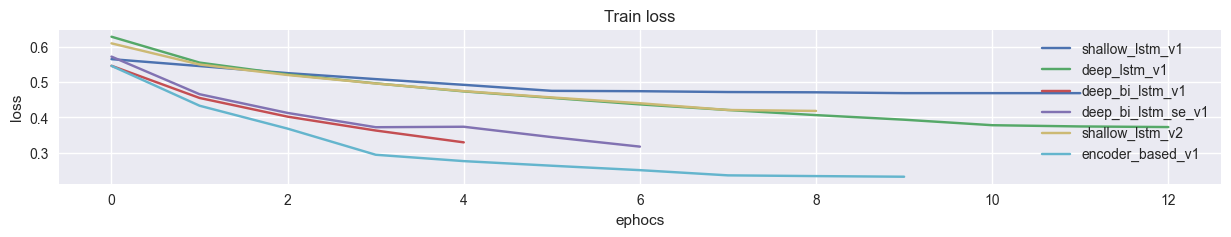

In [74]:
plt.figure(figsize=(15,2))
plt.ylabel('loss')
plt.xlabel('ephocs')
plt.title(f"Train loss")

for i, model in enumerate(models_list):
    plt.plot(model.history['loss'], label=model.name)

plt.legend()
plt.show()

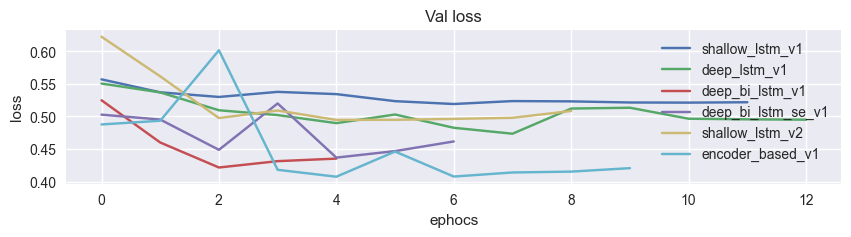

In [75]:
plt.figure(figsize=(10,2))
plt.ylabel('loss')
plt.xlabel('ephocs')
plt.title(f"Val loss")

for i, model in enumerate(models_list):
    plt.plot(model.history['val_loss'], label=model.name)

plt.legend()
plt.show()

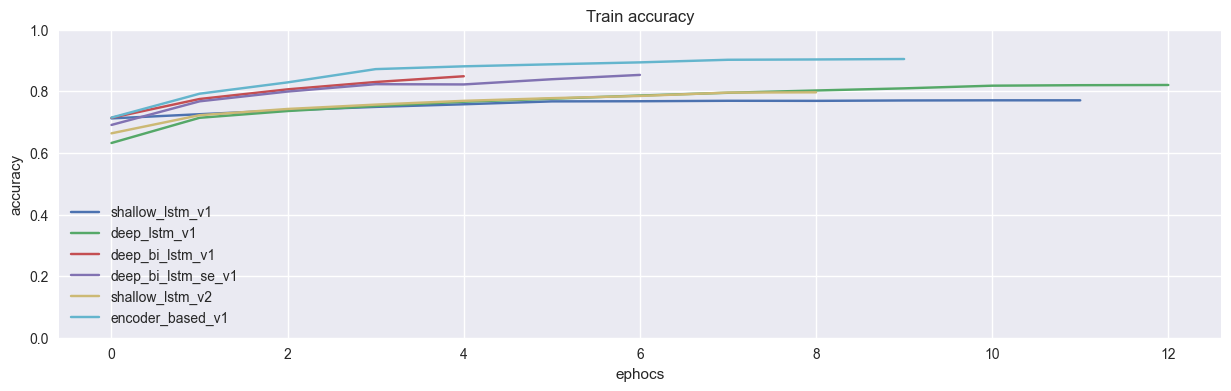

In [76]:
plt.figure(figsize=(15,4))
plt.ylabel('accuracy')
plt.xlabel('ephocs')
plt.title(f"Train accuracy")

for i, model in enumerate(models_list):
    plt.plot(model.history['accuracy'], label=model.name)

plt.legend()
plt.ylim(0,1)
plt.show()

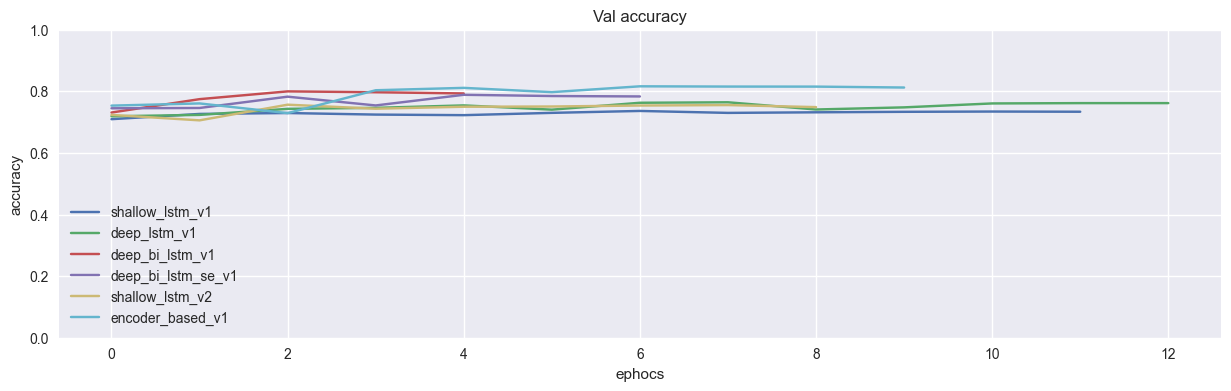

In [77]:
plt.figure(figsize=(15,4))
plt.ylabel('accuracy')
plt.xlabel('ephocs')
plt.title(f"Val accuracy")

for i, model in enumerate(models_list):
    plt.plot(model.history['val_accuracy'], label=model.name)

plt.legend()
plt.ylim(0,1)
plt.show()

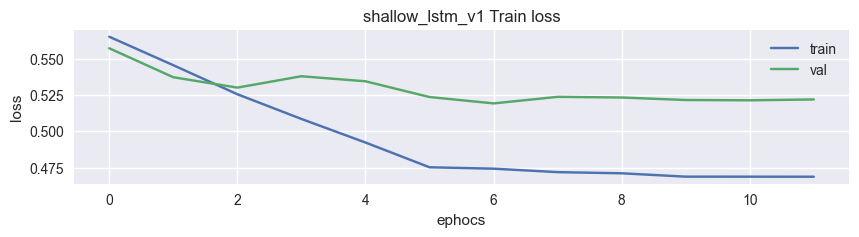

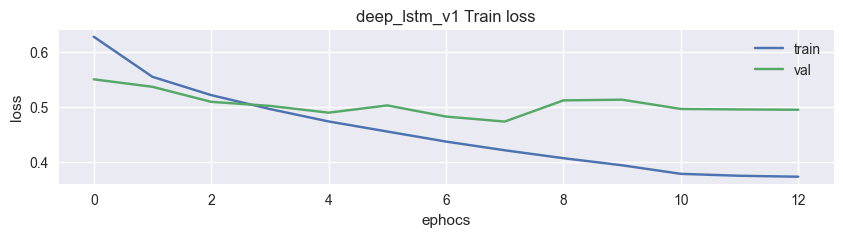

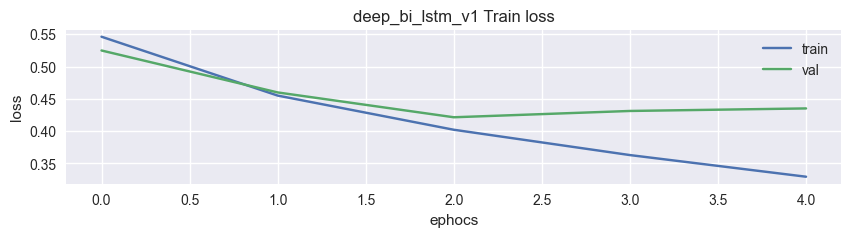

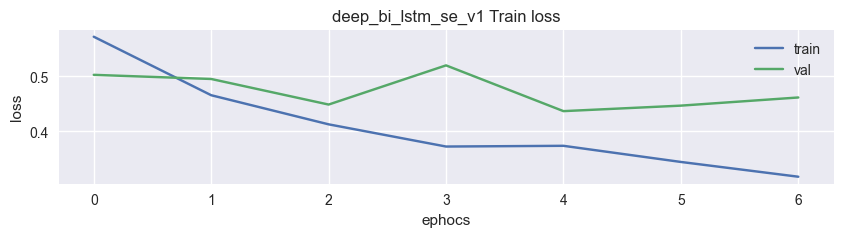

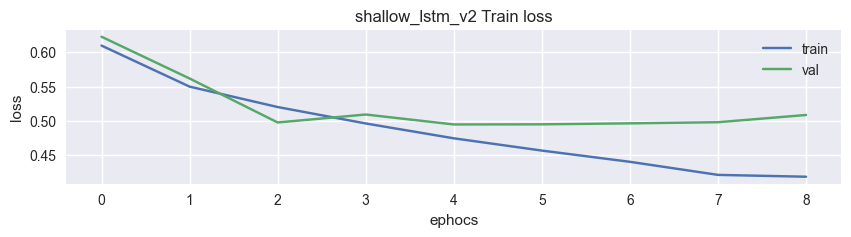

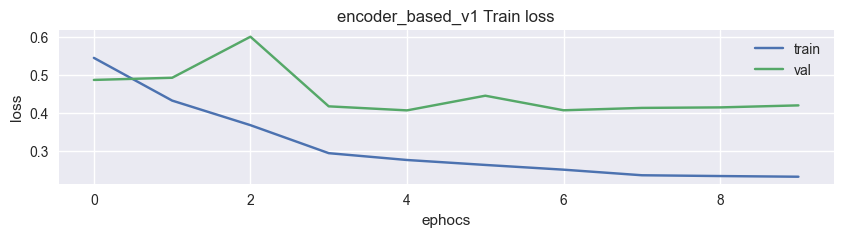

In [78]:
for i, model in enumerate(models_list):
    plt.figure(figsize=(10,2))
    plt.grid(True)
    plt.title(f"{model.name} Train loss")
    plt.ylabel('loss')
    plt.xlabel('ephocs')
    plt.plot(model.history['loss'], label='train')
    plt.plot(model.history['val_loss'], label='val')
    plt.legend()
    plt.show()

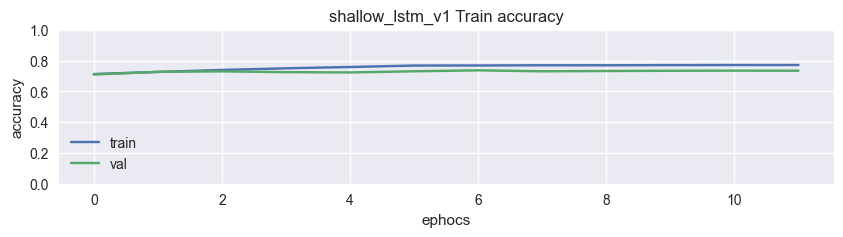

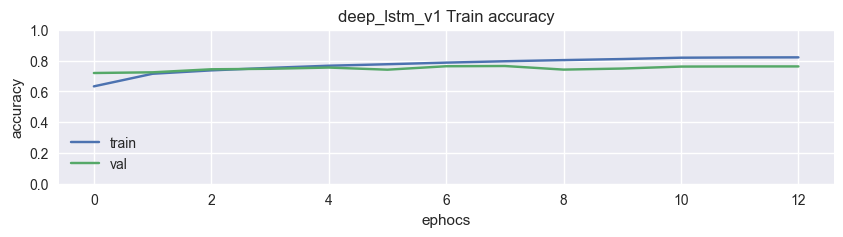

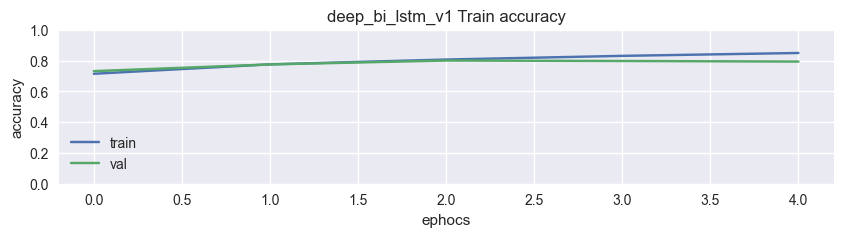

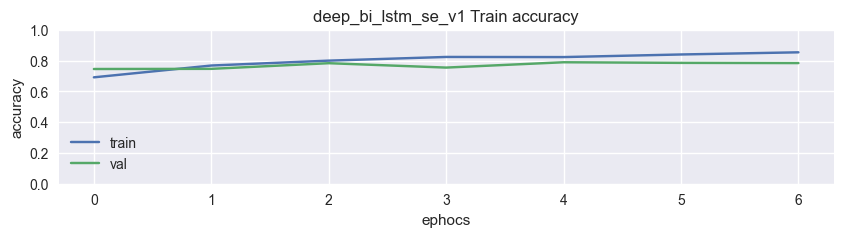

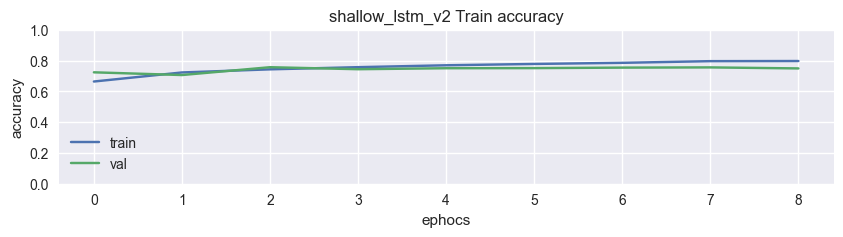

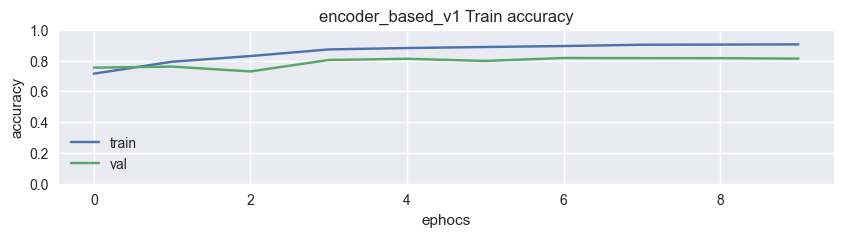

In [79]:
for i, model in enumerate(models_list):
    plt.figure(figsize=(10,2))
    plt.grid(True)
    plt.title(f"{model.name} Train accuracy")
    plt.ylabel('accuracy')
    plt.xlabel('ephocs')
    plt.plot(model.history['accuracy'], label='train')
    plt.plot(model.history['val_accuracy'], label='val')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

# Model Eval

In [80]:
import pandas as pd

results = []

for model in models_list:
    print(f"Model: {model.name}")

    # --- Train ---
    train_loss, train_acc = model.model.evaluate(X_train, y_train, verbose=1, batch_size= BATCH_SIZE)

    # --- Validation ---
    val_loss, val_acc = model.model.evaluate(X_val, y_val, verbose=1, batch_size= BATCH_SIZE)

    # --- Test ---
    test_loss, test_acc = model.model.evaluate(X_test, y_test, verbose=1, batch_size= BATCH_SIZE)

    # Print results
    print(f"Train   -> loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"Val     -> loss: {val_loss:.4f}, acc: {val_acc:.4f}")
    print(f"Test    -> loss: {test_loss:.4f}, acc: {test_acc:.4f}")
    print("\n")

    results.append({
        "Model": model.name,
        "Train Loss": train_loss,
        "Train Acc": train_acc,
        "Val Loss": val_loss,
        "Val Acc": val_acc,
        "Test Loss": test_loss,
        "Test Acc": test_acc
    })

df_results = pd.DataFrame(results)

Model: shallow_lstm_v1
272/272 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.7764 - loss: 0.4574
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.7377 - loss: 0.5126
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7279 - loss: 0.5284
Train   -> loss: 0.4579, acc: 0.7754
Val     -> loss: 0.5191, acc: 0.7363
Test    -> loss: 0.5307, acc: 0.7284


Model: deep_lstm_v1
272/272 ━━━━━━━━━━━━━━━━━━━━ 36s 122ms/step - accuracy: 0.8218 - loss: 0.3839
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7649 - loss: 0.4697
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.7650 - loss: 0.4793
Train   -> loss: 0.3849, acc: 0.8210
Val     -> loss: 0.4735, acc: 0.7644
Test    -> loss: 0.4813, acc: 0.7629


Model: deep_bi_lstm_v1
272/272 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.8346 - loss: 0.3602
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7980 - loss: 0.4218
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7987 - loss: 0.4224
Train   -> loss: 0.3612, acc: 0.8

In [81]:
df_results.to_csv(os.path.join(DEPLOYMENST_PATH,"model_results.csv"), index=False)  
df_results

,Model,Train Loss,Train Acc,Val Loss,Val Acc,Test Loss,Test Acc
0,shallow_lstm_v1,0.457879,0.775368,0.519148,0.736285,0.530672,0.728402
1,deep_lstm_v1,0.384862,0.820975,0.473466,0.764413,0.481282,0.762872
2,deep_bi_lstm_v1,0.361221,0.834450,0.421529,0.799814,0.429193,0.795625
3,deep_bi_lstm_se_v1,0.363908,0.830843,0.436735,0.788731,0.445556,0.785822
4,shallow_lstm_v2,0.440768,0.787516,0.494666,0.749956,0.505689,0.744197
5,encoder_based_v1,0.266881,0.890838,0.407352,0.811216,0.420873,0.807697


# Inference

In [82]:
def predict_fn(model_name, text1, text2):
    model = None

    for m in models_list:
        if m.name == model_name:
            model = m.model
            break

    if model is None:
        return "❌ Model not found"

    x1 = clean_str(text1)
    x2 = clean_str(text2)


    x1 = x_tokenizer.texts_to_sequences([x1])
    x2 = x_tokenizer.texts_to_sequences([x2])

    x1_returned = x_tokenizer.sequences_to_texts(x1)[0]
    x2_returned = x_tokenizer.sequences_to_texts(x2)[0]

    x1 = pad_sequences(x1, maxlen=SENTENCE_MAX_WORDS_LEN, padding='post', truncating='post')
    x2 = pad_sequences(x2, maxlen=SENTENCE_MAX_WORDS_LEN, padding='post', truncating='post')

    x1 = x1.flatten()
    x2 = x2.flatten()

    x = np.array([[x1,x2]])

    y_prop = model.predict(x, verbose=0)
    y_prop = y_prop.flatten()[0]

    if y_prop >= 0.5:
        y_pred = 1
    else:
        y_pred = 0

    return_val = f"Y:{y_pred}, prop: {y_prop:0.2f}"
    return_val += '\n'
    return_val += f"{x1_returned}\n{x2_returned}"

    return return_val

In [83]:
with gr.Blocks() as demo:
    gr.Markdown("Model Picker & Prediction")

    with gr.Row():
        model_dropdown = gr.Dropdown(
            choices=[m.name for m in models_list],
            label="Pick Model"
        )

    text1 = gr.Textbox(label="Input Text 1")
    text2 = gr.Textbox(label="Input Text 2")

    predict_btn = gr.Button("Predict")
    output = gr.Textbox(label="Output")

    predict_btn.click(
        predict_fn,
        inputs=[model_dropdown, text1, text2],
        outputs=[output]
    )

demo.launch(debug=False, share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://84ee03513146734450.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Deployment

In [84]:
save_obj(x_tokenizer, TOKENIZER_PATH)

In [85]:
for model in models_list:
    m = model.model
    name = model.name

    m_path = os.path.join(DEPLOYMENST_PATH, f"{name}.keras")
    m.save(m_path)

    print(f"✅ Saved keras model {m_path}")

✅ Saved keras model deployments\shallow_lstm_v1.keras
✅ Saved keras model deployments\deep_lstm_v1.keras
✅ Saved keras model deployments\deep_bi_lstm_v1.keras
✅ Saved keras model deployments\deep_bi_lstm_se_v1.keras
✅ Saved keras model deployments\shallow_lstm_v2.keras
✅ Saved keras model deployments\encoder_based_v1.keras
